<a href="https://colab.research.google.com/github/DevikalyanDas/Convolution/blob/master/Vision_task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation Task 1
#### Welcome to the first task of Image Segmentation. Image segmentation is the process of partitioning the image into a set of pixels representing an object. In this task, you will be introduced to the problem of image segmentation and programming pipeline involved in image segmentation.

For the purpose of this task we will be using PASCAL VOC datset. The dataset contains a total of 2913 images with segmentation annotations. Code in the cell below will download the code and extract the dataset.

In [1]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xvf VOCtrainval_11-May-2012.tar

Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2012/SegmentationClass/2008_001874.png
VOCdevkit/VOC2012/SegmentationClass/2008_001876.png
VOCdevkit/VOC2012/SegmentationClass/2008_001882.png
VOCdevkit/VOC2012/SegmentationClass/2008_001885.png
VOCdevkit/VOC2012/SegmentationClass/2008_001895.png
VOCdevkit/VOC2012/SegmentationClass/2008_001896.png
VOCdevkit/VOC2012/SegmentationClass/2008_001926.png
VOCdevkit/VOC2012/SegmentationClass/2008_001966.png
VOCdevkit/VOC2012/SegmentationClass/2008_001971.png
VOCdevkit/VOC2012/SegmentationClass/2008_001992.png
VOCdevkit/VOC2012/SegmentationClass/2008_001997.png
VOCdevkit/VOC2012/SegmentationClass/2008_002032.png
VOCdevkit/VOC2012/SegmentationClass/2008_002043.png
VOCdevkit/VOC2012/SegmentationClass/2008_002064.png
VOCdevkit/VOC2012/SegmentationClass/2008_002066.png
VOCdevkit/VOC2012/SegmentationClass/2008_002067.png
VOCdevkit/VOC2012/SegmentationClass/2008_002073.png
VOCdevkit/VOC2012/SegmentationClass/2008_002079.png
VOCdevkit/VOC

In [2]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 111kB/s 
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


### 1.1 Loading the dataset

In [40]:
import numpy as np
from PIL import Image
import random

import torch
from torchvision import transforms as T
from torchvision.transforms import functional as F
################## custom transform  ##################3
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class RandomHorizontalFlip(object):
    def __init__(self, flip_prob):
        self.flip_prob = flip_prob

    def __call__(self, image, target):
        if random.random() < self.flip_prob:
            image = F.hflip(image)
            target = F.hflip(target)
        return image, target

class Resize(object):
    def __call__(self, image, target):
        image = F.resize(image,[256,256]),
        target = F.resize(target,[256,256])
        return np.asarray(image), np.asarray(target)

class ToTensor(object):
    def __call__(self, image, target):
        # print(type(image))
        # image = torch.from_numpy(image)
        # target = torch.from_numpy(image)
        image = F.to_tensor(image)
        target = torch.as_tensor(np.array(target), dtype=torch.int64)
        return image, target


class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image, target):
        image = F.normalize(image, mean=self.mean, std=self.std)
        return image, target

In [4]:
import os
from os.path import join as pjoin
import collections
import json
import torch
import imageio
import numpy as np
import scipy.misc as m
import scipy.io as io
import matplotlib.pyplot as plt
import glob

from PIL import Image
from tqdm import tqdm
from torch.utils import data
from torchvision import transforms


class pascalVOCDataset(data.Dataset):
    """Data loader for the Pascal VOC semantic segmentation dataset.

    Annotations from both the original VOC data (which consist of RGB images
    in which colours map to specific classes) and the SBD (Berkely) dataset
    (where annotations are stored as .mat files) are converted into a common
    `label_mask` format.  Under this format, each mask is an (M,N) array of
    integer values from 0 to 21, where 0 represents the background class.

    The label masks are stored in a new folder, called `pre_encoded`, which
    is added as a subdirectory of the `SegmentationClass` folder in the
    original Pascal VOC data layout.

    A total of five data splits are provided for working with the VOC data:
        train: The original VOC 2012 training data - 1464 images
        val: The original VOC 2012 validation data - 1449 images
        trainval: The combination of `train` and `val` - 2913 images
        train_aug: The unique images present in both the train split and
                   training images from SBD: - 8829 images (the unique members
                   of the result of combining lists of length 1464 and 8498)
        train_aug_val: The original VOC 2012 validation data minus the images
                   present in `train_aug` (This is done with the same logic as
                   the validation set used in FCN PAMI paper, but with VOC 2012
                   rather than VOC 2011) - 904 images
    """

    def __init__(
        self,
        root,
        sbd_path=None,
        split="train_aug",
        is_transform=False,
        img_size=512,
        augmentations=None,
        img_norm=True,
        test_mode=False,
    ):
        self.root = root
        self.sbd_path = sbd_path
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.test_mode = test_mode
        self.n_classes = 21
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.files = collections.defaultdict(list)
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)

        if not self.test_mode:
            for split in ["train", "val", "trainval"]:
                path = pjoin(self.root, "ImageSets/Segmentation", split + ".txt")
                file_list = tuple(open(path, "r"))
                file_list = [id_.rstrip() for id_ in file_list]
                self.files[split] = file_list
            self.setup_annotations()
################################ train transform #############################
        self.tf = Compose(                                                   
            [                                                                
                # add more trasnformations as you see fit
                # Resize(),                                                                           
                RandomHorizontalFlip(0.3),                                    
                ToTensor(),                                                  
                Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

            ]                                                                
        )                                                                    
#############################################################################
################################ test transform #############################
        self.tf_test = Compose(                                             
            [                                                                                                                  
                ToTensor(),                                                 
                Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]                                                               
        )                                                                   
#############################################################################
    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        im_name = self.files[self.split][index]
        im_path = pjoin(self.root, "JPEGImages", im_name + ".jpg")
        lbl_path = pjoin(self.root, "SegmentationClass/pre_encoded", im_name + ".png")
        im = Image.open(im_path)
        lbl = Image.open(lbl_path)
        if self.augmentations is not None:
            im, lbl = self.augmentations(im, lbl)
        if self.is_transform == 'for_train':
            im, lbl = self.transform(im, lbl,'for_train') 
        elif self.is_transform == 'for_test':
            im, lbl = self.transform(im, lbl,'for_test')             
        
        return im, torch.clamp(lbl, max=20)

    def transform(self, img, lbl,set_ind):
        if self.img_size == ("same", "same"):
            pass
        else:
            img = img.resize((self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
            lbl = lbl.resize((self.img_size[0], self.img_size[1]))
        if set_ind == 'for_train':
            img,lbl = self.tf(img,lbl)
        elif set_ind == 'for_test':
            img,lbl = self.tf_test(img,lbl)
        lbl = torch.from_numpy(np.array(lbl)).long()
        lbl[lbl == 255] = 0
        return img, lbl

    def get_pascal_labels(self):
        """Load the mapping that associates pascal classes with label colors

        Returns:
            np.ndarray with dimensions (21, 3)
        """
        return np.asarray(
            [
                [0, 0, 0],
                [128, 0, 0],
                [0, 128, 0],
                [128, 128, 0],
                [0, 0, 128],
                [128, 0, 128],
                [0, 128, 128],
                [128, 128, 128],
                [64, 0, 0],
                [192, 0, 0],
                [64, 128, 0],
                [192, 128, 0],
                [64, 0, 128],
                [192, 0, 128],
                [64, 128, 128],
                [192, 128, 128],
                [0, 64, 0],
                [128, 64, 0],
                [0, 192, 0],
                [128, 192, 0],
                [0, 64, 128],
            ]
        )

    def encode_segmap(self, mask):
        """Encode segmentation label images as pascal classes

        Args:
            mask (np.ndarray): raw segmentation label image of dimension
              (M, N, 3), in which the Pascal classes are encoded as colours.

        Returns:
            (np.ndarray): class map with dimensions (M,N), where the value at
            a given location is the integer denoting the class index.
        """
        mask = mask.astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for ii, label in enumerate(self.get_pascal_labels()):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
        label_mask = label_mask.astype(int)
        # print(np.unique(label_mask))
        return label_mask

    def decode_segmap(self, label_mask, plot=False):
        """Decode segmentation class labels into a color image

        Args:
            label_mask (np.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.

        Returns:
            (np.ndarray, optional): the resulting decoded color image.
        """
        label_colours = self.get_pascal_labels()
        r = label_mask.copy()
        g = label_mask.copy()
        b = label_mask.copy()
        for ll in range(0, self.n_classes):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb

    def setup_annotations(self):
        """Sets up Berkley annotations by adding image indices to the
        `train_aug` split and pre-encode all segmentation labels into the
        common label_mask format (if this has not already been done). This
        function also defines the `train_aug` and `train_aug_val` data splits
        according to the description in the class docstring
        """
        sbd_path = self.sbd_path
        target_path = pjoin(self.root, "SegmentationClass/pre_encoded")
        if not os.path.exists(target_path):
            os.makedirs(target_path)
        train_aug = self.files["train"]

        # keep unique elements (stable)
        train_aug = [train_aug[i] for i in sorted(np.unique(train_aug, return_index=True)[1])]
        self.files["train_aug"] = train_aug
        set_diff = set(self.files["val"]) - set(train_aug)  # remove overlap
        self.files["train_aug_val"] = list(set_diff)

        pre_encoded = glob.glob(pjoin(target_path, "*.png"))
        expected = np.unique(self.files["train_aug"] + self.files["val"]).size

        if len(pre_encoded) != expected:
            print("Pre-encoding segmentation masks...")

            for ii in tqdm(self.files["trainval"]):
                fname = ii + ".png"
                lbl_path = pjoin(self.root, "SegmentationClass", fname)
                lbl = self.encode_segmap(m.imread(lbl_path))
                lbl = m.toimage(lbl, high=lbl.max(), low=lbl.min())
                m.imsave(pjoin(target_path, fname), lbl)

        assert expected == 2913, "unexpected dataset sizes"

### 1.2 Define the model architecture(2.0 point)
In this section you have the freedom to decide your own model. Keep in mind though, to perform image segmentation, you need to implement an architecture that does pixel level classification i.e. for each pixel in the image you need to predict the probability of it belonging to one of the 21 categories.

In [9]:
# we have defined a Unet model for Segmentation

import torch
import torch.nn as nn
from torchsummary import summary

def conv_block_bn(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=out_channels),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=out_channels)
    )

class Segnet(nn.Module):
  
    def __init__(self,n_class):
        super(Segnet, self).__init__()
        #define the layers for your model
        self.conv_down1 = conv_block_bn(3, 64)
        self.conv_down2 = conv_block_bn(64, 128)
        self.conv_down3 = conv_block_bn(128, 256)
        self.conv_down4 = conv_block_bn(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.conv_up3 = conv_block_bn(256 + 512, 256)
        self.conv_up2 = conv_block_bn(128 + 256, 128)
        self.conv_up1 = conv_block_bn(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64,out_channels= n_class,kernel_size= 1)
    

    def forward(self, x):
        #define the forward pass
        conv_1 = self.conv_down1(x)
        conv_1_mp = self.maxpool(conv_1)

        conv_2 = self.conv_down2(conv_1_mp)
        conv_2_mp = self.maxpool(conv_2)

        conv_3 = self.conv_down3(conv_2_mp)
        conv_3_mp = self.maxpool(conv_3)     

        conv_4 = self.conv_down4(conv_3_mp)

        up_3 = self.upsample(conv_4)
        up_cat_3 = torch.cat([up_3, conv_3], dim=1)
        up_conv_3 = self.conv_up3(up_cat_3)

        up_2 = self.upsample(up_conv_3)
        up_cat_2 = torch.cat([up_2, conv_2], dim=1)
        up_conv_2 = self.conv_up2(up_cat_2)

        up_1 = self.upsample(up_conv_2)
        up_cat_1 = torch.cat([up_1, conv_1], dim=1)
        up_conv_1 = self.conv_up1(up_cat_1)  
        out = self.conv_last(up_conv_1)
        return out
 

In [10]:
# Creating an instance of the model defined above. 
# You can modify it incase you need to pass paratemers to the constructor.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Segnet(n_class=21)
model = model.to(device)

summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
       BatchNorm2d-3         [-1, 64, 256, 256]             128
            Conv2d-4         [-1, 64, 256, 256]          36,928
              ReLU-5         [-1, 64, 256, 256]               0
       BatchNorm2d-6         [-1, 64, 256, 256]             128
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
              ReLU-9        [-1, 128, 128, 128]               0
      BatchNorm2d-10        [-1, 128, 128, 128]             256
           Conv2d-11        [-1, 128, 128, 128]         147,584
             ReLU-12        [-1, 128, 128, 128]               0
      BatchNorm2d-13        [-1, 128, 128, 128]             256
        MaxPool2d-14          [-1, 128,

### 1.3 Hyperparameters(0.5 points)
Define all the hyperparameters(not restricted to the three given below) that you find useful here.

In [4]:
local_path = 'VOCdevkit/VOC2012/' # modify it according to your device
bs = 8
epochs = 100

### 1.4 Dataset and Dataloader(0.5 points)
Create the dataset using pascalVOCDataset class defined above. Use local_path defined in the cell above as root. 

In [ ]:
# dataset variable
dst = pascalVOCDataset(root=local_path, is_transform='for_train',split="train",img_size=256)

# dataloader variable
trainloader = data.DataLoader(dst, batch_size = bs)

In [ ]:
val_dst = pascalVOCDataset(root=local_path, is_transform='for_test',split="val",img_size=256)

lengths = [int(len(val_dst)*0.5)+1, int(len(val_dst)*0.5)]

# Splitting the val data into validation and train
validation_1, test_1 = torch.utils.data.dataset.random_split(val_dst,lengths)

# dataloader variable for validation
val_loader = data.DataLoader(validation_1, batch_size = bs)
# dataloader variable for Test
test_loader = data.DataLoader(test_1, batch_size = bs)

seeing a batch of train images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


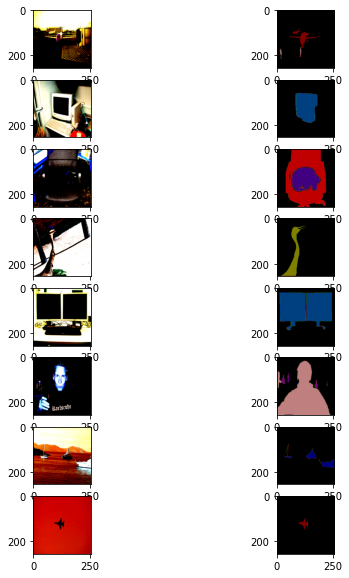

In [73]:
imgs, labels = next(iter(trainloader))
imgs = imgs.numpy()[:, ::-1, :, :]
imgs = np.transpose(imgs, [0,2,3,1])
f, axarr = plt.subplots(bs, 2,figsize=(8, 10))
for j in range(bs):
    axarr[j][0].imshow(imgs[j].astype(np.float32))
    axarr[j][1].imshow(dst.decode_segmap(labels.numpy()[j].astype(np.uint8)))
plt.show()

batch of val images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


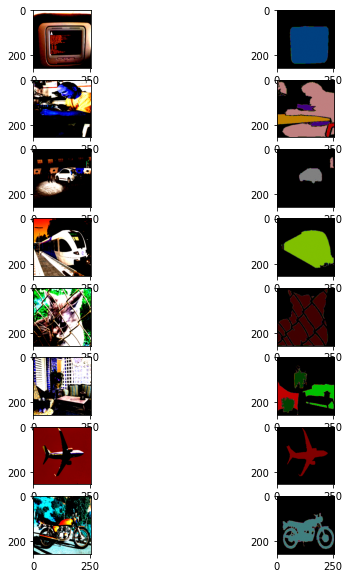

In [ ]:
imgs, labels = next(iter(val_loader))
imgs = imgs.numpy()[:, ::-1, :, :]
imgs = np.transpose(imgs, [0,2,3,1])
f, axarr = plt.subplots(bs, 2,figsize=(8, 10))
for j in range(bs):
    axarr[j][0].imshow(imgs[j].astype(np.float32))
    axarr[j][1].imshow(dst.decode_segmap(labels.numpy()[j].astype(np.uint8)))
plt.show()

### 1.5 Loss fuction and Optimizer(1.0 point)
Define below with the loss function you think would be most suitable for segmentation task. You are free to choose any optimizer to train the network.

In [11]:
# loss function
loss_f = torch.nn.CrossEntropyLoss()
# loss_f = FocalLoss2d(weights=None,ignore_index=None)

# optimizer variable
opt = torch.optim.Adam(model.parameters(), lr=0.001)

### 1.6 Training the model(3.0 points)
Your task here is to complete the code below to perform a training loop and save the model weights after each epoch of training.

In [14]:
loss_history={"train": [],"val": [],"epoch":[]}
best_loss = float('inf')
filepath = '/content/weights/weights.pt'   # weights save path
for e in range(epochs):
    model.train()
    for i, d in enumerate(trainloader):
        inputs_, targets_ = d
        inputs, targets = inputs_.to(device), targets_.to(device)

        opt.zero_grad()
        outputs = model(inputs)

        loss = loss_f(outputs, targets)
        loss.backward()     
        opt.step()

    loss_history["train"].append(loss.item())
    state = {
             'epoch': e,
             'state_dict': model.state_dict(),
             'optimizer': opt.state_dict()
             }
    ############ validation loss #############
    if e%10==0:
        model.eval()
        with torch.no_grad():
            for val_i, val_d in enumerate(val_loader):
                val_inputs_, val_targets_ = val_d
                val_inputs, val_targets = val_inputs_.to(device), val_targets_.to(device)
                val_outputs = model(val_inputs)
                val_loss = loss_f(val_outputs, val_targets)
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save(state, filepath)

            print(" Validation loss after %d epochs: %.6f" %(e,val_loss.item()))
    torch.save(state, filepath)
    print("Epoch: %d, train loss: %.6f" %(e,loss.item()))
    print("-"*10)

print('Finished Training')

    # your code goes here

 Validation loss after 0 epochs: 1.186404
Epoch: 0, train loss: 1.077142
----------
Epoch: 1, train loss: 1.072459
----------
Epoch: 2, train loss: 1.061023
----------
Epoch: 3, train loss: 1.047400
----------
Epoch: 4, train loss: 1.013666
----------
Epoch: 5, train loss: 1.006311
----------
Epoch: 6, train loss: 1.045379
----------
Epoch: 7, train loss: 1.007818
----------
Epoch: 8, train loss: 0.986979
----------
Epoch: 9, train loss: 0.986600
----------
 Validation loss after 10 epochs: 1.074870
Epoch: 10, train loss: 0.958285
----------
Epoch: 11, train loss: 0.964209
----------
Epoch: 12, train loss: 0.987513
----------
Epoch: 13, train loss: 0.903376
----------
Epoch: 14, train loss: 0.916279
----------
Epoch: 15, train loss: 0.890717
----------
Epoch: 16, train loss: 0.895441
----------
Epoch: 17, train loss: 0.875795
----------
Epoch: 18, train loss: 0.813847
----------
Epoch: 19, train loss: 0.806561
----------
 Validation loss after 20 epochs: 1.097012
Epoch: 20, train loss:

### 1.7 Evaluate your model(1.5 points)
In this section you have to implement the evaluation metrics for your model. Calculate the values of F1-score, dice coefficient and AUC-ROC score on the data you used for training. You can use external packages like scikit-learn to compute above metrics.

In [107]:
from sklearn.metrics import f1_score,roc_auc_score
################ dice coefficient straight imported from stack over flow ##############
#  https://stackoverflow.com/a/61494375
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice/numLabels # taking average

def evaluate(ground_truth, predictions):
    pred = torch.argmax(predictions, dim=1)
    # ground_truth = torch.nn.functional.one_hot(ground_truth)
    # pred = pred.permute(0,2,3,1)
    # ground_truth = ground_truth.permute(0,2,3,1)
    f1_,auc_,dice_= [], [], []
    for n in range(bs):
        pred_num = pred[n].cpu().detach().numpy()
        gt_num = ground_truth[n].cpu().detach().numpy()
        
        num_lab = len(np.unique(gt_num))
        pred_flat = pred_num.flatten()
        gt_flat = pred_num.flatten()
        new_pred_list = pred_flat
        for unique_item in np.unique(pred_flat):
            if unique_item not in gt_flat:
                new_pred_list.remove(unique_item)
        # print(np.unique(gt_flat))
        # print(np.unique(new_pred_list))
        # f1_sc = f1_score(gt_flat, new_pred_list,labels='macro',average='macro')
        fi = F1Score(pred,ground_truth)
        f1_.a
        # auc_ = roc_auc_score(gt_flat, new_pred_list,labels='macro',average='macro')
        # dc_ = dice_coef_multilabel(gt_num, pred_num,num_lab)
    f1_sc = np.mean(f1_)
    auc_sc = np.mean(auc_)
    dice_coeff = np.mean(dice_)
    return f1_sc, auc_sc, dice_coeff

In [102]:
class Precision:
    """
    Computes precision of the predictions with respect to the true labels.
    Args:
        y_true: Tensor of Ground truth values.
        y_pred: Tensor of Predicted values.
        epsilon: Fuzz factor to avoid division by zero. default: `1e-10`
    Returns:
        Tensor of precision score
    """

    def __init__(self, epsilon=1e-10):
        self.epsilon = epsilon

    def __call__(self, y_pred, y_true):
        true_positives = torch.sum(torch.round(torch.clip(y_pred * y_true, 0, 1)))
        predicted_positives = torch.sum(torch.round(torch.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + self.epsilon)
        return precision


class Recall:
    """
    Computes recall of the predictions with respect to the true labels.
    Args:
        y_true: Tensor of Ground truth values.
        y_pred: Tensor of Predicted values.
        epsilon: Fuzz factor to avoid division by zero. default: `1e-10`
    Returns:
        Tensor of recall score
    """

    def __init__(self, epsilon=1e-10):
        self.epsilon = epsilon

    def __call__(self, y_pred, y_true):
        true_positives = torch.sum(torch.round(torch.clip(y_pred * y_true, 0, 1)))
        actual_positives = torch.sum(torch.round(torch.clip(y_true, 0, 1)))
        recall = true_positives / (actual_positives + self.epsilon)
        return recall

In [103]:
# from torch_metrics.classification.pr import Precision, Recall
class F1Score:
    """
    Computes F1-score between `y_true` and `y_pred`.
    Args:
        y_true: Tensor of Ground truth values.
        y_pred: Tensor of Predicted values.
        epsilon: Fuzz factor to avoid division by zero. default: `1e-10`
    Returns:
        Tensor of F1-score
    """

    def __init__(self,y_pred,y_true, epsilon=1e-10):
        self.epsilon = epsilon
        self.precision = Precision()
        self.recall = Recall()
        self.y_pred = y_pred
        self.y_true = y_true
    def __call__(self, y_pred, y_true):
        precision = self.precision(y_pred, y_true)
        recall = self.recall(y_pred, y_true)
        return 2 * ((precision * recall) / (precision + recall + self.epsilon))

In [108]:
from torch.nn import functional
the_model = torch.load('/content/weights/weights.pt')
model_val = Segnet(n_class=21)
model_val.to(device)
model_val.eval()
model_val.load_state_dict(model.state_dict())

eval_history={"f1_score": [],"auc_score": [],"dice": [],"epoch":[]}
with torch.no_grad():
    for i, d in enumerate(trainloader):
        inputs_, targets_ = d
        inputs, targets = inputs_.to(device), targets_.to(device)

        outputs = model_val(inputs)
        outputs = functional.softmax(outputs)
        f1_sc,auc_sc,dc_sc = evaluate(targets,outputs)
        print(f1_sc,auc_sc,dc_sc)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


TypeError: ignored

In [ ]:
for i, d in enumerate(trainloader):
    inputs_, targets_ = d
    inputs, targets = inputs_.to(device), targets_.to(device)
for n,kl in enumerate(targets):
    print(targets_[n].size()) 

In [33]:
len(targets)

8

In [28]:
the_model['epoch']

99

### 1.8 Plot the evaluation metrics against epochs(1.0)
In section 1.6 we saved the weights of the model after each epoch. In this section, you have to calculate the evaluation metrics after each epoch of training by loading the weights for each epoch. Once you have calculated the evaluation metrics for each epoch, plot them against the epochs.

### 1.9 Visualize results(0.5 points)
For any 10 images in the dataset, show the images along the with their segmentation mask.

torch.Size([8, 256, 256])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for

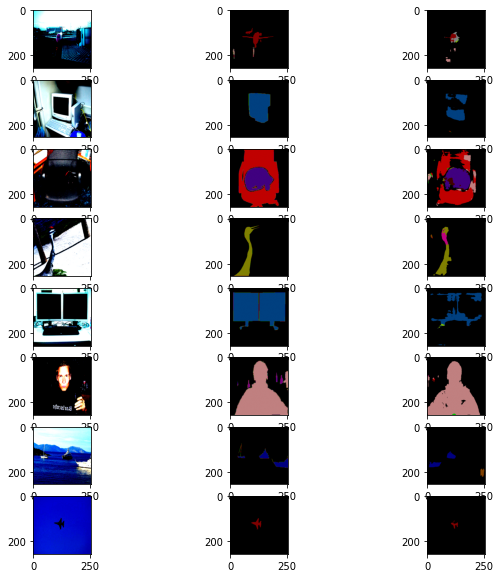

In [78]:
imgs, labels = next(iter(trainloader))
print(labels.shape)
imgs = imgs.numpy()[:, ::-1, :, :]
imgs = np.transpose(imgs, [0,2,3,1])
segmented = model_val(inputs)
segmented = functional.softmax(segmented)
segmented = torch.argmax(segmented, dim=1).cpu()
f, axarr = plt.subplots(bs, 3,figsize=(10, 10))
for j in range(bs):
    axarr[j][0].imshow(imgs[j].astype(np.float32))
    axarr[j][1].imshow(dst.decode_segmap(labels.numpy()[j].astype(np.uint8)))
    axarr[j][2].imshow(dst.decode_segmap(segmented.numpy()[j].astype(np.uint8)))
plt.show()